In [1]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import numpy as np

import scipy.signal as signal
import scipy.ndimage.filters as filters
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

import svm 
import svmutil

# Image Quality Assessment

Image quality is a notion that highly depends on observers. Generally, 
it is linked to the conditions in which it is viewed; therefore, a highly subjective topic. Image quality assessment aims to quantitatively represent the human perception of quality. These metrics commonly are used to analyze the performance of algorithms in different fields of computer vision like image compression, image transmission, and image processing [1].

Image quality assessment (IQA) is mainly divided into two areas of research (1) reference-based evaluation and (2)  no-reference evaluation. The main difference is that reference-based methods depend on a high-quality image as a source to evaluate the difference between images. An example of reference-based evaluations is the Structural Similarity Index (SSIM) [2].

## No-reference Image Quality Assessment

No-reference image quality assessment does not require a base image to evaluate an image quality, the only information that the algorithm receives is the distorted image whose quality is being assessed.

Blind methods are mostly comprised of two steps. The first step calculates features that describe the image's structure and the second step relates the features with the human opinion of the image quality. TID2008 is a famous database created following a methodology that describes how to measure human opinion scores from referenced images [3], it is widely used to compare the performance of IQA algorithms.

## Blind/referenceless image spatial quality evaluator (BRISQUE)

BRISQUE [4] is a model that only used the image pixels to calculate features (other methods are based on image transformation to other spaces like wavelet or DCT). It is demonstrated to be highly efficient as it does not need any transformation to calculate its features.

It relies on spatial Natural Scene Statistics (NSS) model of locally normalized luminance coefficients in the spatial domain, as well as the model for pairwise products of these coefficients. 

## Methodology
### Natural Scene Statistics in the Spatial Domain
Given an image $I(i, j)$, first, compute the locally normalized luminances $\hat{I}(i,j)$ via local mean subtraction $\mu(i,j)$ and divide it by the local deviation $\sigma(i, j)$. $C$ is added to avoid zero divisions. 

$$\hat{I}(i,j) = \frac{I(i,j) - \mu(i,j)}{\sigma(i,j) + C}$$

*Hint: If $I(i,j)$'s domain is [0,255] then $C=1$ if the domain is [0,1] then $C=1/255$.* 

To calculate the locally normalized luminance, also known as mean substracted contrast normalized (MSCN) coefficients, first, we need to calculate the local mean

$$\mu(i,j) = \sum_{k=-K}^{K}\sum_{l=-L}^{L}w_{k,l}I_{k,l}(i,j)$$

where $w$ is a Gaussian kernel of size (K, L).

The way that the author displays the local mean could be a little bit confusing but it is just applying a Gaussian filter to the image.

In [2]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

Then, we calculate the local deviation

$$ \sigma(i,j) = \sqrt{\sum_{k=-K}^{K}\sum_{l=-L}^{L}w_{k,l}(I_{k,l}(i, j) - \mu(i, j))^2 } $$

In [3]:
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

Finally, we calculate the MSCN coefficients

$$\hat{I}(i,j) = \frac{I(i,j) - \mu(i,j)}{\sigma(i,j) + C}$$

In [4]:
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

The author found that the MSCN coefficients are distributed as a Generalized Gaussian Distribution (GGD) for a broader spectrum of distorted image.

$$f(x; \alpha, \sigma^2) = \frac{\alpha}{2\beta\Gamma(1/\alpha)}e^{-\big(\frac{|x|}{\beta}\big)^\alpha}$$

where

$$\beta = \sigma \sqrt{\frac{\Gamma\big(\frac{1}{\alpha}\big)}{\Gamma\big(\frac{3}{\alpha}\big)}}$$

and $\Gamma$ is the gamma function.

The shape $\alpha$ controls the shape and $\sigma^2$ th variance.

In [5]:
def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

### Pairwise products of neighboring MSCN coefficients

The signs of adjacent coefficients also exhibit a regular structure, which gets disturbed in the presence of distortion. The author proposes the model of pairwise products of neighboring MSCN coefficients along four directions (1) horizontal $H$, (2) vertical $V$, (3) main-diagonal $D1$ and (4) secondary-diagonal $D2$.

$$H(i,j) = \hat{I}(i,j) \hat{I}(i, j + 1)$$
$$V(i,j) = \hat{I}(i,j) \hat{I}(i + 1, j)$$
$$D1(i,j) = \hat{I}(i,j) \hat{I}(i + 1, j + 1)$$
$$D2(i,j) = \hat{I}(i,j) \hat{I}(i + 1, j - 1)$$

In [6]:
def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

The author mentions that the Generalized Gaussian Distribution does not provide good fit to the empirical histograms of coefficient producs. Thus, they propose the Asymmetric Generalized Gaussian Distribution (AGGD) model [5].

$$
f(x; \nu, \sigma_l^2, \sigma_r^2) =  
   \begin{cases} 
      \frac{\nu}{(\beta_l + \beta_r)\Gamma\big(\frac{1}{\nu}\big)}e^{\big(-\big(\frac{-x}{\beta_l}\big)^\nu\big)} & x < 0 \\
        \frac{\nu}{(\beta_l + \beta_r)\Gamma\big(\frac{1}{\nu}\big)}e^{\big(-\big(\frac{x}{\beta_r}\big)^\nu\big)} & x >= 0
\end{cases}
$$

where

$$\beta_{side} = \sigma_{side} \sqrt{\frac{\Gamma\big(\frac{1}{\nu}\big)}{\Gamma\big(\frac{3}{\nu}\big)}}$$

and $side$ can be either $r$ or $l$.

Another parameter that is not reflected in the previous formula is the mean

$$\eta = (\beta_r - beta_l) \frac{\Gamma\big(\frac{2}{\nu}\big)}{\Gamma\big(\frac{1}{\nu}\big)}$$

In [7]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

### Fitting Asymmetric Generalized Gaussian Distribution

The methodology to fit an Asymmetric Generalized Gaussian Distribution is described in [5].

1. Calculate $\hat{\gamma}$ where $N_l$ is the number of negative samples and $N_r$ is the number of positive samples. 

$$
\hat{\gamma} = \frac{\sqrt{\frac{1}{N_l - 1}\sum_{k=1, x_k < 0}^{N_l} x_k^2}
}{\sqrt{\frac{1}{N_r - 1}\sum_{k=1, x_k >= 0}^{N_r} x_k^2}
}
$$

2. Calculate $\hat{r}$.

$$\hat{r} = \frac{\big(\frac{\sum|x_k|}{N_l + N_r}\big)^2}{\frac{\sum{x_k ^ 2}}{N_l + N_r}} $$

3. Calculate $\hat{R}$ using $\hat{\gamma}$ and $\hat{r}$ estimations.

$$\hat{R} = \hat{r} \frac{(\hat{\gamma}^3 + 1)(\hat{\gamma} + 1)}{(\hat{\gamma}^2 + 1)^2}$$

4. Estimate $\alpha$ using the approximation of the inverse generalized Gaussian ratio.

$$\hat{\alpha} = \hat{\rho} ^ {-1}(\hat{R})$$

$$\rho(\alpha) = \frac{\Gamma(2 / \alpha) ^ 2}{\Gamma(1 / \alpha) \Gamma(3 / \alpha)}$$

5. Estimate left and right scale parameters.
$$\sigma_l = \sqrt{\frac{1}{N_l - 1}\sum_{k=1, x_k < 0}^{N_l} x_k^2}$$
$$\sigma_r = \sqrt{\frac{1}{N_r - 1}\sum_{k=1, x_k >= 0}^{N_r} x_k^2}$$

In [8]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

### Calculate BRISQUE features

The features needed to calculate the image quality are the result of fitting the MSCN coefficients and shifted products to the Generalized Gaussian Distributions. First, we need to fit the MSCN coefficients to the GDD, then the pairwise products to the AGGD. A summary of the features is the following:

| Feature ID      | Feature Description                            | Computation Procedure            |
|-----------------|------------------------------------------------|----------------------------------|
| $f_1-f_2$       | Shape and variance                             | Fit GGD to MSCN coefficients     |
| $f_3-f_6$       | Shape, mean, left variance, right variance     | Fit AGGD to H pairwise products  |
| $f_7-f_{10}$    | Shape, mean, left variance, right variance     | Fit AGGD to V pairwise products  |
| $f_{11}-f_{14}$ | Shape, mean, left variance, right variance     | Fit AGGD to D1 pairwise products |
| $f_{15}-f_{18}$ | Shape, mean, left variance, right variance     | Fit AGGD to D2 pairwise products |

In [9]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

# Hands-on

After creating all the functions needed to calculate the brisque features, we can estimate the image quality for a given image. In [4], they use an image that comes from the Kodak dataset [6].

## Auxiliary Functions

In [17]:
def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')

## 1. Load image

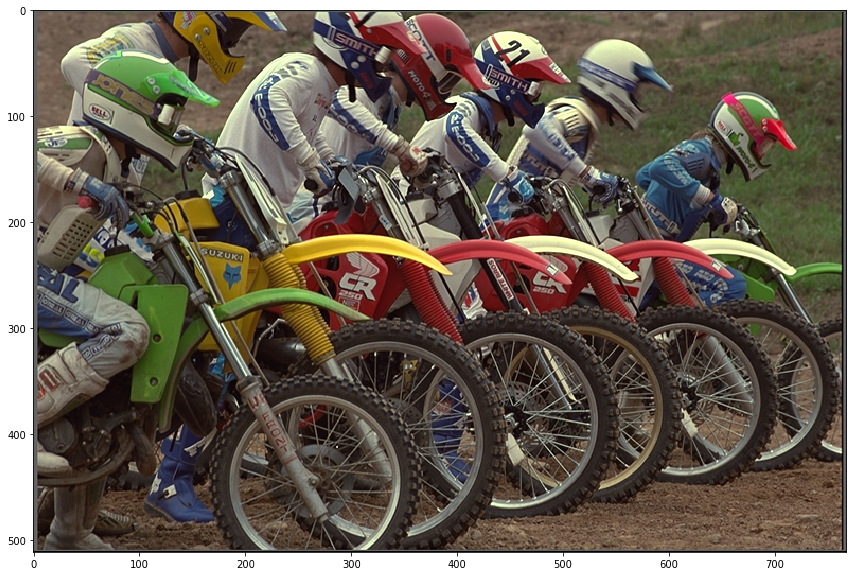

In [18]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 9

url = 'http://www.cs.albany.edu/~xypan/research/img/Kodak/kodim05.png'
image = load_image(url)
gray_image = skimage.color.rgb2gray(image)

_ = skimage.io.imshow(image)

## 2. Calculate Coefficients

In [32]:
%%time 

mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
coefficients = calculate_pair_product_coefficients(mscn_coefficients)

CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 91.4 ms


After calculating the MSCN coefficients and the pairwise products, we can verify that the distributions are in fact different.

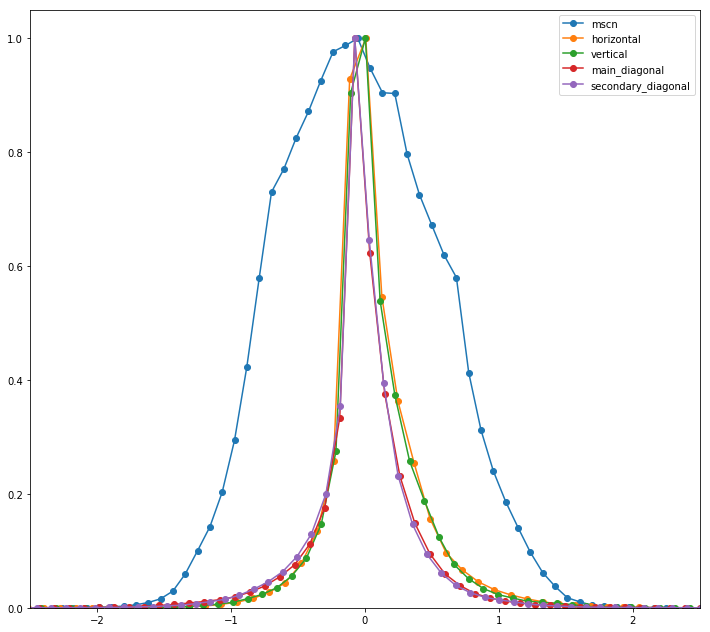

In [33]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 11

for name, coeff in coefficients.items():
    plot_histogram(coeff.ravel(), name)

plt.axis([-2.5, 2.5, 0, 1.05])
plt.legend()
plt.show()

## 3. Fit Coefficients to Generalized Gaussian Distributions 

In [46]:
%%time 

brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 138 ms


## 4. Resize Image and Calculate BRISQUE Features

In [47]:
%%time

downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 36 ms


## 5. Scale Features and Feed the SVR
The author provides a pretrained SVR model to calculate the quality assessment. However, in order to have good results, we need to scale the features to [-1, 1]. For the latter, we need the same parameters the author used to scale the features vector.

In [48]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

The scaled used to represent image quality goes from 0 to 100. An image quality of 100 means that the image's quality is very bad. In the case of the analyzed image, we get that it is a good quality image. It makes sense because we are using the reference image.

In [49]:
%%time

calculate_image_quality_score(brisque_features)

CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 12.7 ms


4.954157281562374

## Conclusion

This method was tested with the TID2008 database and performs well; even compared with referenced IQA methods. Although, the future work is to check the performance of other machine learning algorithms like XGBoost, LightGBM, for the pattern recognition step.

## References

[1] Maître, H. (2017). From Photon to pixel: the digital camera handbook. John Wiley & Sons.

[2] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: from error visibility to structural similarity. IEEE transactions on image processing, 13(4), 600-612.

[3] Ponomarenko, N., Lukin, V., Zelensky, A., Egiazarian, K., Carli, M., & Battisti, F. (2009). TID2008-a database for evaluation of full-reference visual quality assessment metrics. Advances of Modern Radioelectronics, 10(4), 30-45.

[4] Mittal, A., Moorthy, A. K., & Bovik, A. C. (2012). No-reference image quality assessment in the spatial domain. IEEE Transactions on Image Processing, 21(12), 4695-4708.

[5] Lasmar, N. E., Stitou, Y., & Berthoumieu, Y. (2009). Multiscale skewed heavy-tailed model for texture analysis. Proceedings - International Conference on Image Processing, ICIP, (1), 2281–2284.